This notebook evaluates the performance of bayesian classification models.  The place from whence the 

<ul>
    <li>pickle of a developed model, and supplementary parameters <span style="color:darkolivegreen;font-weight: bold">[pocket.pkl]</span></li>
    <li>testing data [<b>testing.csv</b>]</li>
    <li>model trace [<b>trace.zip</b>]</li>
    <li>definitions of any categorical fields [<b>definitionsOfCategories.json</b>]</li>
    <li>mappings of polytomous categorical fields and their t-SNE embedding transforms [<b>mappings.json</b>]</li>
</ul>

are downloaded is outlined in a bash script file, which is `scripts.sh` herein.

<br>

One final input, the **fields of interest for disaggregated performance evaluation**

In [1]:
fields = ['female', 'housing', 'savings_acc_class', 'e_chq_acc_status']

<br>
<br>

## Preliminaries

### Packages & Libraries

In [2]:
%%bash

rm -rf delta
unzip -u -q delta.zip

<br>

**Packages**

In [3]:
import subprocess

In [4]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)


<br>

**Libraries**

In [5]:
import logging
import collections
import pathlib
import requests

import os
import sys
import json
import codecs

import pickle
import theano

import numpy as np
import pandas as pd
import scipy.optimize
import re
import dask

import sklearn.decomposition
import sklearn.metrics

import pymc3
import graphviz
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
pymc3.__version__

'3.11.2'

In [7]:
dask.__version__

'2.30.0'

<br>

### Logging

In [8]:
logging.basicConfig(level=logging.WARNING, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [9]:
import delta.modules

In [10]:
delta.modules.Modules().exc()

<br>

Graphs

In [11]:
relational = delta.graphing.relational.Relational()
RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [12]:
settings = delta.graphing.settings.Settings()
settings.layout()
settings.aesthetics()

<br>

Paths

In [13]:
if not 'google.colab' in str(get_ipython()):    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
else:
    parent = os.getcwd()  

In [45]:
directory = os.path.join(parent, 'warehouse', 'evaluations')

for string in [os.path.join(directory, 'model'),
               os.path.join(directory, 'model', 'loss'), 
               os.path.join(directory, 'disaggregates', 'frequencies'),
               os.path.join(directory, 'disaggregates', 'metrics'), 
               os.path.join(directory, 'disaggregates', 'scores')]:
    if not os.path.exists(string):
        os.makedirs(string)

<br>
<br>

## Model

Preparatory steps of an auditor or a client.  It predominantly involves reading-in objects, e.g., reading-in

* The delivered model.
* A trace object if dealing with a Bayesian model. 
* Test data; structured according defined specifications.

In [15]:
SEED = 5
rng = np.random.default_rng(seed=SEED)

<br>

### Pickle

In [16]:
with open(os.path.join('data', 'pocket.pkl'), 'rb') as f:
            pickled = f.read()
            f.close()

pocket = pickle.loads(pickled)
pocket.keys()

dict_keys(['lm', 'ndraws', 'nchains', 'xshared', 'target', 'regressors', 'binary_cf_dictionary', 'scaler'])

Hence

In [17]:
lm = pocket['lm']
scaler = pocket['scaler']
xshared = pocket['xshared']

<br>

### Trace

A summary of each trace is available via

```
with lm:
    summary = pymc3.summary(data=trace)
summary.head()
```

In [18]:
with lm:
    trace = pymc3.backends.ndarray.load_trace(directory=os.path.join('trace'))

<br>

### Setting Up

**Testing Data**

In [19]:
try:
    testingdata = pd.read_csv(filepath_or_buffer=os.path.join('data', 'testing.csv'))
except OSError as err:
    raise Exception(err.strerror) in err

In [24]:
f_ = open(file=os.path.join('data', 'mappings.json'), mode='rb')
mappings = json.load(f_)
f_.close()

if bool(mappings):
    extraneous = list(mappings.keys())
else:
    extraneous = []

<br>

**Model Parameters**

In [25]:
ModelParameters = collections.namedtuple(
    typename='ModelParameters', field_names=['ndraws', 'nchains', 'regressors', 'target', 'extraneous'])

In [26]:
model_parameters = ModelParameters._make(
    (pocket['ndraws'], pocket['nchains'], pocket['regressors'].split(','), pocket['target'], extraneous))

<br>
<br>

## Predict

### Test Data

The setting-up of test data involves

* Scaling
* Structuring: `x_testing_` $\longleftarrow$ `regressors`, `y_testing_` $\longleftarrow$ `target`

In [27]:
preprocessing = delta.algorithms.preprocessing.Preprocessing(parameters=model_parameters, scaler=scaler)
x_testing_, y_testing_ = preprocessing.exc(frame=testingdata)

<br>
<br>

### Posterior Predictive Checks

Predictions w.r.t. a test set.  Ascertain

* $\small{ samples \gt (trace.report.n\_draws \times trace.nchains) }$
* *assert* $\:$ $\small{nsamples > (ndraws * nchains)}$, $\;$  *'# of samples > ( # of draws * # of chains) is required'*

In [28]:
nsamples = 1000 + (model_parameters.ndraws * model_parameters.nchains)

In [ ]:
with lm:
    xshared.set_value(new_value=x_testing_)
    ppc = pymc3.sample_posterior_predictive(trace=trace, samples=nsamples, 
                                            random_seed=SEED, var_names=['y'] + trace.varnames)

In [30]:
plausibilities = ppc['y'].mean(axis=0)
uncertainty = ppc['y'].std(axis=0)

<br>
<br>

### Loss

Focused on

* Loss Curves<br>
$- \; [Y^{^{\small{T}}}_{n \times 1} \: \odot \: ln(P_{\tau \times n})] \; - \; [(1 - Y^{^{\small{T}}}_{n \times 1}) \: \odot \: ln(1 - P_{\tau \times n})] \; $

* Loss Curve<br>
$- \; [Y_{n \times 1} \: \cdot \: ln(\mathbf{\rho}_{_{n \times 1}})] \; - \; [(1 - Y_{n \times 1}) \: \cdot \: ln(1 - \mathbf{\rho}_{_{n \times 1}})] \; $

wherein

$\qquad$ $\mathbf{\rho}$: plausibilities <br>
$\qquad$ $Y$: y_testing_.values <br>
$\qquad$ $P$: ppc['y']

Loss Calculations

In [ ]:
LossParameters = collections.namedtuple(typename='LossParameters', 
                                        field_names=['n_samples', 'm_selections', 'k_averages'])
lossparameters = LossParameters._make((nsamples, 1000, 500))

loss, lossmatrix = delta.error.loss.Loss(target=y_testing_.values, posterior=ppc['y'], 
                             plausibilities=plausibilities, lossparameters=lossparameters).exc()

In [33]:
loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   plausibilities  350 non-null    float64
 1   target          350 non-null    int64  
 2   losscurve_u     350 non-null    float64
 3   losscurve_l     350 non-null    float64
 4   losscurve       350 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 13.8 KB


<br>

Save

In [65]:
for i in loss.target.unique():

    name = '{:02d}'.format(i)

    C = loss['target'] == i
    K = lossmatrix[:,1] == i

    # Curve
    curve = loss.loc[C, :]
    points = curve.drop(columns='target').to_dict(orient='records')

    with open(os.path.join(directory, 'model', 'loss', name + 'CURVE.json'), 'w') as disk:
        json.dump(points, disk)

    # Curves
    points = np.concatenate((lossmatrix[K, 0:1], lossmatrix[K, 2:]), axis=1)
    lists = points.tolist()
    json.dump(lists, 
          codecs.open(os.path.join(directory, 'model', 'loss', name + 'CURVES.json'), 
                      'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=False,
          indent=4)


<br>
<br>

## Error Matrix & Performance

The series of threshold values for which error matrix values, and their derivatives, are calculated.

In [66]:
thresholds = np.arange(start=0.01, stop=0.99, step=0.005)

<br>

The target field/s

In [67]:
if type(model_parameters.target) != list:
    classes = [model_parameters.target]
else:
    classes = model_parameters.target   

<br>

Problem type.  A binary problem will have a single frame of frequencies.  A multi-class problem will have a seperate table of frequencies per class; subsequently the tables are analysed separately & together.

In [68]:
if len(classes) > 1:
    binary = False
else:
    binary = True

<br>

Evaluation Properties

In [69]:
EvaluationProperties = collections.namedtuple(
    typename='EvaluationProperties', field_names=['thresholds', 'classes', 'target'])
evaluation_properties = EvaluationProperties._make((thresholds, classes, model_parameters.target))

<br>

Categories

In [70]:
with open(os.path.join('data', 'definitionsOfCategories.json'), 'r') as blob:
    definitions = json.load(blob)

<br>

Arguments

In [71]:
Arguments = collections.namedtuple(typename='Arguments', field_names=['optimal', 'definitions', 'directory']) 

<br>
<br>

### Frequencies & Metrics

In [72]:
T = delta.binary.derivations.model.Model(properties=evaluation_properties).\
    exc(plausibilities=plausibilities, truth=y_testing_)
logger.warning(T.info())    

None
2021-08-05 18:44:39.944


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   threshold          187 non-null    float64
 1   tp                 187 non-null    int64  
 2   fn                 187 non-null    int64  
 3   tn                 187 non-null    int64  
 4   fp                 187 non-null    int64  
 5   precision          187 non-null    float64
 6   sensitivity        187 non-null    float64
 7   specificity        187 non-null    float64
 8   fpr                187 non-null    float64
 9   fscore             187 non-null    float64
 10  youden             187 non-null    float64
 11  matthews           187 non-null    float64
 12  balanced_accuracy  187 non-null    float64
 13  standard_accuracy  187 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 20.6 KB


<br>
<br>

### Optimal Threshold Strategy

The index of the optimal $\:T\:$ instance w.r.t. the

* **Maximum Matthews Correlation Coefficient**<br>
```
index = T.matthews.idxmax()
```

* **Intersection, cross-over, point of the precision & sensitivity curves**<br>
```
differences = T.precision - T.sensitivity
index = (differences.abs()).idxmin()
```

In [73]:
differences = T.precision - T.sensitivity
index_of_optimal = (differences.abs()).idxmin()
optimal = T.iloc[index_of_optimal, :].threshold

logger.warning(optimal)

0.38999999999999996
2021-08-05 18:48:08.044


<br>

Graph

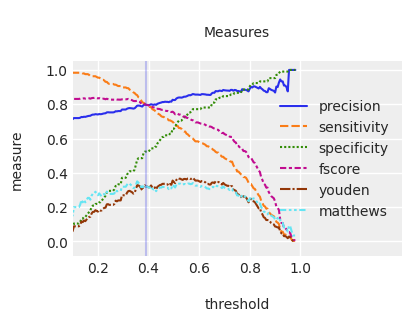

In [74]:
graph = delta.graphing.error.Error(blob=T, which='dependent')
graph.exc(optimal=optimal)

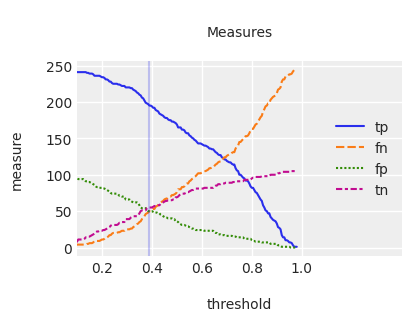

In [75]:
graph = delta.graphing.error.Error(blob=T, which='independent')
graph.exc(optimal=optimal)

<br>
<br>

### Model

**Save T**

The frequencies & metrics at each threshold point

In [77]:
arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'model')))

delta.binary.graphing.details.model.Model(blob=T, arguments=arguments).\
    exc()

And

In [85]:
T[['threshold', 'tp', 'fn', 'tn', 'fp']].to_csv(path_or_buf=os.path.join(directory, 'model', 'frequencies.csv'), header=True, 
                   index=False, encoding='UTF-8')

T[['threshold', 'precision', 'sensitivity', 'specificity', 'fpr', 'fscore', 'youden', 
   'matthews', 'balanced_accuracy', 'standard_accuracy']].to_csv(path_or_buf=os.path.join(directory, 'model', 'metrics.csv'), header=True, 
                   index=False, encoding='UTF-8')

Delete

In [79]:
T.to_csv(path_or_buf=os.path.join(directory, 'model', 'error.csv'), header=True, 
                   index=False, encoding='UTF-8')

<br>

**Save Estimate**

A data vector that consists of the:

* Frequencies & metrics at the optimal threshold.

* ROC Area, i.e., the area under the _**true positive rate/false positive rate**_ curve.

* PTC Area, i.e., the area under the _**precision/true positive rate**_ curve.


In [81]:
estimate = T.copy().iloc[index_of_optimal:(index_of_optimal + 1),:]
ROC = sklearn.metrics.auc(x=(1 - T.specificity), y=T.sensitivity)
PTC = sklearn.metrics.auc(x=T.sensitivity, y=T.precision)
estimate.loc[:, 'roc'] = ROC
estimate.loc[:, 'ptc'] = PTC


arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'model')))

delta.binary.graphing.scores.model.Model(
    blob=estimate, arguments=arguments).exc()

<br>
<br>

### Disaggregates

The reference data set, which includes the

* original forms of embedded polytomous categorical fields
* classification plausibilities
* field of estimated/assigned class w.r.t. plausibilities and a threshold

In [82]:
reference = testingdata.copy()
reference.loc[:, 'estimated'] = (plausibilities > optimal).astype(int)
reference.loc[:, 'plausibilities'] = plausibilities

<br>

**Frequencies & Metrics**

In [83]:
J = delta.binary.derivations.disaggregates.Disaggregates(fields=fields, properties=evaluation_properties).\
    exc(blob=reference)
logger.warning(J.info())    

None
2021-08-05 19:11:40.788


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   threshold          2227 non-null   float64
 1   tp                 2227 non-null   int64  
 2   fn                 2227 non-null   int64  
 3   tn                 2227 non-null   int64  
 4   fp                 2227 non-null   int64  
 5   precision          2227 non-null   float64
 6   sensitivity        2227 non-null   float64
 7   specificity        2227 non-null   float64
 8   fpr                2227 non-null   float64
 9   fscore             2227 non-null   float64
 10  youden             2227 non-null   float64
 11  matthews           2227 non-null   float64
 12  balanced_accuracy  2227 non-null   float64
 13  standard_accuracy  2227 non-null   float64
 14  field              2227 non-null   object 
 15  element            2227 non-null   object 
dtypes: float64(10), int64(4)

<br>

**Save J**

Disaggregated frequencies & metrics

In [84]:
arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'disaggregates')))

for field in fields:

    blob = J[J['field'] == field]
    elements = blob['element'].unique()

    delta.binary.graphing.details.disaggregates.Disaggregates(
        field=field, elements=elements, blob=blob, arguments=arguments).exc()

<br>

And

In [86]:
J[['threshold', 'tp', 'fn', 'tn', 'fp', 'field', 'element']].\
    to_csv(path_or_buf=os.path.join(directory, 'model', 'frequencies.csv'), 
           header=True, index=False, encoding='UTF-8')

J[['threshold', 'precision', 'sensitivity', 'specificity', 'fpr', 'fscore', 
   'youden', 'matthews', 'balanced_accuracy', 'standard_accuracy', 'field', 'element']].\
    to_csv(path_or_buf=os.path.join(directory, 'model', 'metrics.csv'), 
           header=True, index=False, encoding='UTF-8')

<br>

Delete

In [87]:
J.to_csv(path_or_buf=os.path.join(directory, 'disaggregates', 'error.csv'), header=True, 
                     index=False, encoding='UTF-8')

<br>

**Save Decompositions**

The J instances whereby $\small{threshold \equiv optimal \; threshold}$


In [88]:
decompositions = J[J['threshold'] == optimal]

arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'disaggregates', 'scores')))

operator = delta.binary.graphing.scores.disaggregates.Disaggregates(blob=decompositions, arguments=arguments)
for field in fields:
    operator.exc(field=field)

<br>
<br>

## Zip

In [89]:
!rm -rf evaluations.zip
!zip -r evaluations.zip warehouse/evaluations/

  adding: warehouse/evaluations/ (stored 0%)
  adding: warehouse/evaluations/model/ (stored 0%)
  adding: warehouse/evaluations/model/frequencies.csv (deflated 89%)
  adding: warehouse/evaluations/model/loss/ (stored 0%)
  adding: warehouse/evaluations/model/loss/01CURVE.json (deflated 73%)
  adding: warehouse/evaluations/model/loss/01CURVES.json (deflated 94%)
  adding: warehouse/evaluations/model/loss/00CURVE.json (deflated 72%)
  adding: warehouse/evaluations/model/loss/00CURVES.json (deflated 93%)
  adding: warehouse/evaluations/model/error.csv (deflated 77%)
  adding: warehouse/evaluations/model/metrics.csv (deflated 89%)
  adding: warehouse/evaluations/model/frequencies.json (deflated 88%)
  adding: warehouse/evaluations/model/metrics.json (deflated 86%)
  adding: warehouse/evaluations/model/scores.json (deflated 39%)
  adding: warehouse/evaluations/disaggregates/ (stored 0%)
  adding: warehouse/evaluations/disaggregates/error.csv (deflated 89%)
  adding: warehouse/evaluations/di